In [2]:
import pandas as pd
import gensim.downloader as api
import nltk
from gensim.models import KeyedVectors

import sys 
sys.path.append('/Users/jessicahassibi/PycharmProjects/bachelor-thesis/src/data') # replace with your absolute path
sys.path.append('/Users/jessicahassibi/PycharmProjects/bachelor-thesis/src/models')
# import modules from another folder
import WikiScraper
import data_analysis
import ttl_word2vec

In [55]:
from importlib import reload
reload(ttl_word2vec)

<module 'ttl_word2vec' from '/Users/jessicahassibi/PycharmProjects/bachelor-thesis/src/models/ttl_word2vec.py'>

In [4]:
# languages in which the articles shall be crawled
languages = ['de', 'en', 'ar', 'fr', 'es', 'it']

# new instance of WikiScraper
wiki_scraper = WikiScraper.WikiScraper()

# Scrape list of persecuted composers
persecuted_composers_page = "Liste der vom NS-Regime oder seinen Verbündeten verfolgten Komponisten"
wiki_scraper.scrape_pages_multiple_languages(persecuted_composers_page, languages)

# Scrape list of supported composers
supported_composers_page = "Gottbegnadeten-Liste"
wiki_scraper.scrape_pages_multiple_languages(supported_composers_page, languages)

New WikiScraper initialized.

Texts have already been scraped to: ../data/persecuted_composers/de_texts_composers_persecuted.json
Texts have already been scraped to: ../data/persecuted_composers/en_texts_composers_persecuted.json
Texts have already been scraped to: ../data/persecuted_composers/ar_texts_composers_persecuted.json
Texts have already been scraped to: ../data/persecuted_composers/fr_texts_composers_persecuted.json
Texts have already been scraped to: ../data/persecuted_composers/es_texts_composers_persecuted.json
Texts have already been scraped to: ../data/persecuted_composers/it_texts_composers_persecuted.json
Texts have already been scraped to: ../data/supported_composers/de_texts_composers_supported.json
Texts have already been scraped to: ../data/supported_composers/en_texts_composers_supported.json
Texts have already been scraped to: ../data/supported_composers/ar_texts_composers_supported.json
Texts have already been scraped to: ../data/supported_composers/fr_texts_com

In [5]:
####################################################################################################################################
####################################################################################################################################
# Methods to get Word Embeddings

In [185]:
# english dataframe of supported composers
en_df_supported = data_analysis.get_dataframe_from_path("../data/supported_composers/en_texts_composers_supported.json")
en_df_persecuted = data_analysis.get_dataframe_from_path("../data/persecuted_composers/en_texts_composers_persecuted.json")

In [186]:
# create english train dataframe using texts and labels
en_df = pd.DataFrame()
en_df["text"] = pd.concat([en_df_supported["text"], en_df_persecuted["text"]], ignore_index=True)
en_df["label"] = pd.concat([en_df_supported["label"], en_df_persecuted["label"]], ignore_index=True)

In [189]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
import re

# TODO: make it work for all langs
# TODO: numbers/years  as stop words?
def clean_texts(text, lang="english"):
    """
    Cleans data by applying tokenization, removal of stop words
    """
    tokens = []
    punctuation_marks = [",", ".", ";", ":", "-", '"', '""', "''" "'", "(", ")", "[", "]", "!", "?", "=", "{", "}", "&"]
    for sent in sent_tokenize(text, lang):
        for token in word_tokenize(sent, lang):
            token = token.lower()
            if not is_stop_word(token, lang) and token not in punctuation_marks:
                # additionally lemmatize?!
                tokens.append(token)
    return tokens

def is_stop_word(word, lang):
    sw = stopwords.words(lang)
    sw.append("isbn")
    if word in sw:
        return True
    elif re.match(r"\d+", word): # e.g. "1" or "20" but not a year (1994) as it may contain historical information:
        return True
    else:
        return False
    

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jessicahassibi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [190]:
# TODO: geburtsdaten cleanen
# insert new column to dataframe with cleaned text
language = "english"
en_df.insert(1, "cleaned_text", en_df["text"].apply(lambda x: clean_texts(x, language)))
en_df

,text,cleaned_text,label
0,Richard Georg Strauss (German: [ˈʁɪçaʁt ˈʃtʁaʊ...,"[richard, georg, strauss, german, ˈʁɪçaʁt, ˈʃt...",supported
1,Hans Erich Pfitzner (5 May 1869 – 22 May 1949)...,"[hans, erich, pfitzner, may, –, may, german, c...",supported
2,Johann Nepomuk David (30 November 1895 – 22 De...,"[johann, nepomuk, david, november, –, december...",supported
3,"Werner Egk (German pronunciation: [ˈɛk], 17 Ma...","[werner, egk, german, pronunciation, ˈɛk, may,...",supported
4,Harald Genzmer (9 February 1909 – 16 December ...,"[harald, genzmer, february, –, december, germa...",supported
...,...,...,...
207,Władysław Szpilman (Polish pronunciation: [vwa...,"[władysław, szpilman, polish, pronunciation, v...",persecuted
208,Zikmund Schul (11 January 1916 – 2 June 1944) ...,"[zikmund, schul, january, –, june, german, jew...",persecuted
209,"World War II or the Second World War, often ab...","[world, war, ii, second, world, war, often, ab...",persecuted
210,Ödön Pártos [alternate transcription in Englis...,"[ödön, pártos, alternate, transcription, engli...",persecuted


In [146]:
from sklearn.model_selection import train_test_split

# Encoding the label column
en_df['label']=en_df['label'].map({'supported':1,'persecuted':0})

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split (en_df['cleaned_text'], en_df['label'] , test_size=0.3)

In [204]:
print(X_train.values)

[list(['władysław', 'szpilman', 'polish', 'pronunciation', 'vwaˈdɨswaf', 'ˈʂpʲilman', '5', 'december', '1911', '–', '6', 'july', '2000', 'polish', 'pianist', 'classical', 'composer', 'jewish', 'descent', 'szpilman', 'widely', 'known', 'central', 'figure', '2002', 'roman', 'polanski', 'film', 'pianist', 'based', 'szpilman', "'s", 'autobiographical', 'account', 'survived', 'german', 'occupation', 'warsaw', 'holocaust', 'szpilman', 'studied', 'piano', 'music', 'academies', 'berlin', 'warsaw', 'became', 'popular', 'performer', 'polish', 'radio', 'concert', 'confined', 'within', 'warsaw', 'ghetto', 'german', 'invasion', 'poland', 'szpilman', 'spent', 'two', 'years', 'hiding', 'towards', 'end', 'concealment', 'helped', 'wilm', 'hosenfeld', 'german', 'officer', 'detested', 'nazi', 'policies', 'world', 'war', 'ii', 'szpilman', 'resumed', 'career', 'polish', 'radio', 'szpilman', 'also', 'prolific', 'composer', 'oeuvre', 'included', 'hundreds', 'songs', 'many', 'orchestral', 'pieces', 'szpilman'

In [11]:
"""# not so good
# Train a bigram detector.

bigram_transformer = Phrases(all_sentences_processed)

# Apply the trained MWE detector to a corpus, using the result to train a Word2vec model.
# Gensim implementiert Word2Vec-Algorithmus für das Training der Wortvektoren

model = gensim.models.Word2Vec(bigram_transformer[all_sentences_processed], min_count=2)"""

'# not so good\n# Train a bigram detector.\n\nbigram_transformer = Phrases(all_sentences_processed)\n\n# Apply the trained MWE detector to a corpus, using the result to train a Word2vec model.\n# Gensim implementiert Word2Vec-Algorithmus für das Training der Wortvektoren\n\nmodel = gensim.models.Word2Vec(bigram_transformer[all_sentences_processed], min_count=2)'

In [147]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=X_train, vector_size= 100, min_count=1)
# or:
#model = gensim.models.Word2vec(size=100, min_count=1, workers=4)
#model.build_vocab(all_sentences_processed, progress_per=10)
#model.train(all_sentences_processed, total_examples=model.corpus_count, epochs=model.epochs)

In [148]:
model.save("../models/word2vec_15Aug.model")
# save keyed vectors
wv = model.wv
wv.save('../models/word_vectors/word2vec_15Aug.kv')

In [149]:
# load Word2Vec model
#model = Word2Vec.load("../models/word2vec_15Aug.model")
# load model as KeyedVectors
model = ttl_word2vec.load_word2vec_keyed_vectors("../models/word_vectors/word2vec_15Aug.kv")

Model:  ../models/word_vectors/word2vec_15Aug.kv  loaded


In [150]:
# use pretrained glove vectors
# by downloading them manually
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from pathlib import Path
from gensim.scripts.glove2word2vec import glove2word2vec

file_path: Path = Path("../models/word_vectors/glove.6B.100d.txt").resolve()
glove_file = datapath(file_path)
tmp_file = get_tmpfile("glove2word2vec.txt")
_ = glove2word2vec(glove_file, tmp_file)

pretrained_model = ttl_word2vec.load_word2vec_keyed_vectors(tmp_file)

/var/folders/l3/frtmx2rs13jbzz5v93rn68z00000gn/T/ipykernel_61779/852787625.py:11: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  _ = glove2word2vec(glove_file, tmp_file)


KeyboardInterrupt: 

In [152]:
# save when created first
pretrained_model.save("../models/word_vectors/pretrained_model.kv")
# load when file already exists
pretrained_model= ttl_word2vec.load_word2vec_keyed_vectors("../models/word_vectors/pretrained_model.kv")

Model:  ../models/word_vectors/pretrained_model.kv  loaded


In [153]:
# or with gensim method 
#glove_vectors = api.load("glove-wiki-gigaword-100")
type(glove_vectors)

gensim.models.keyedvectors.KeyedVectors

In [154]:
# explore the vocabulary
from itertools import islice
list(islice(glove_vectors.index_to_key, 13030, 13035))

['innovations', 'penh', 'bangalore', 'freshwater', 'hurled']

In [20]:
# Model with pretrained vectors (just english)
# try fasttext vectors in several languages
# bert has multilingual CONTEXTUAL word vectors (later;))
missing_words = ttl_word2vec.get_words_in_static_embbedings(glove_vectors, words, '../models/words/pretrained_model.txt')

"""# TODOS:
# add bigram detector?
# add missing word if occurs e.g. 3 times? if possible and makes sense... 
sentences =[["test"]]
model.build_vocab(sentences)
model.intersect_word2vec_format(pretrained_model, lockf=1.0, binary=True) 
model.train(sentences, total_examples=3, epochs = 5)
"""

NameError: name 'words' is not defined

In [21]:
# Compare pretrained and manually trained model
# most_similar() finds the cosine similarity of the given word with 
# other words using their Word2Vec representations
glove_vectors.most_similar('mahler')
wv.most_similar('mahler')

[('beethoven', 0.8245475888252258),
 ('brahms', 0.8222415447235107),
 ('schubert', 0.7393962144851685),
 ('symphonies', 0.7230659127235413),
 ('mendelssohn', 0.7181515097618103),
 ('haydn', 0.7120912075042725),
 ('schumann', 0.6914582252502441),
 ('symphony', 0.6797301769256592),
 ('mozart', 0.679054856300354),
 ('schoenberg', 0.6758646368980408)]

In [ ]:
glove_vectors.distance("schönberg", "webern")
model.wv.distance("schönberg", "webern")

In [ ]:
glove_vectors.similarity(w1="composer", w2="nazi")
wv.similarity(w1="composer", w2="nazi")

In [ ]:
wv.doesnt_match(['pianist', 'violinist', 'nazi'])
wv.most_similar(positive=["komponist", "jew"], negative=["schönberg"])
"mahler" in wv.key_to_index.keys()

In [ ]:
# Text Classification on pretrained and manually trained Word2Vec model

In [ ]:
# create features from text for machine learning model
# method 1: averaging word vectors for each text

In [155]:
import numpy as np

def text2vec(text, keyed_vectors):
    # takes gensim KeyedVectors object  and pandas series object of preprocessed sentences
    # and maps each word in the sentences to the corrseponding vector 
    # returns numpy array (for the text) of numpy arrays (sentences) of vectors (words)

    words = set(keyed_vectors.index_to_key)
    text_vect = np.array([np.array([keyed_vectors[i] for i in sentence if i in words])
                             for sentence in text])
    return text_vect

In [156]:
X_train_vect = text2vec(X_train, wv)
X_test_vect = text2vec(X_test, wv)

/var/folders/l3/frtmx2rs13jbzz5v93rn68z00000gn/T/ipykernel_61779/4009939311.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  text_vect = np.array([np.array([keyed_vectors[i] for i in sentence if i in words])


In [157]:
def average_vector(text_vect):
    # Compute sentence vectors by averaging the word vectors for the words contained in the sentence
    avg = []
    for sentence in text_vect:
        if sentence.size:
            avg.append(sentence.mean(axis=0))
        else:
            avg.append(np.zeros(100, dtype=float))
    return avg

In [158]:
X_train_vect_avg = average_vector(X_train_vect)
X_test_vect_avg = average_vector(X_test_vect)

In [159]:
# Instantiate and fit a basic Random Forest model on top of the vectors
from sklearn.ensemble import RandomForestClassifier

def random_forest_prediction(X_train_avg, X_test_avg, y_train_data):
    rf = RandomForestClassifier()
    rf_model = rf.fit(X_train_avg, y_train_data.values.ravel())
    # Use the trained model to make predictions on the test data
    y_pred_data = rf_model.predict(X_test_avg)
    return y_pred_data

In [160]:
y_pred = random_forest_prediction(X_train_vect_avg, X_test_vect_avg, y_train)

In [161]:
from sklearn.metrics import precision_score, recall_score

def calc_metrics(y_test_data, y_pred_data):
    precision = precision_score(y_test_data, y_pred_data)
    recall = recall_score(y_test_data, y_pred_data)
    print('Precision: {} / Recall: {} / Accuracy: {}'.format(
        round(precision, 3), round(recall, 3), round((y_pred_data==y_test_data).sum()/len(y_pred_data), 3)))
# high accuracy but low precision!!!! imbalanced dataset

In [162]:
calc_metrics(y_test, y_pred)

Precision: 0.0 / Recall: 0.0 / Accuracy: 0.922


/Users/jessicahassibi/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:ylabel='label'>

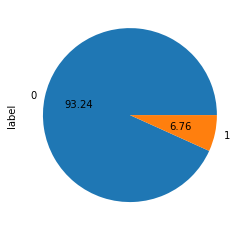

In [163]:
y_train.value_counts().plot.pie(autopct='%0.2f')

In [216]:
# solution:
# Undersampling: reduce majority class to make it equal to minority class
# Oversampling: increase minority class to make it equal to majority class through resampling
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="not majority")
X_train_2d = X_train.values.reshape(-1, 1) # puts each elem of array in own array
X_res, y_res = ros.fit_resample(X_train_2d, y_train)

###############################################################
###############################################################
###############################################################


0    138
1    138
Name: label, dtype: int64

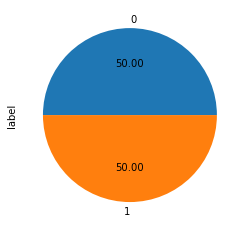

In [217]:
y_res.value_counts().plot.pie(autopct='%0.2f')
y_res.value_counts()

In [242]:
#X_res revert 2_dimensionality
X_res_1d = X_res.flatten()

In [244]:
# classification with resampled vectors
X_res_vect = text2vec(X_res_1d, wv)
X_res_vect_avg = average_vector(X_res_vect)

/var/folders/l3/frtmx2rs13jbzz5v93rn68z00000gn/T/ipykernel_61779/4009939311.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  text_vect = np.array([np.array([keyed_vectors[i] for i in sentence if i in words])


In [249]:
# what test vector? also resampled?
y_res_pred = random_forest_prediction(X_res_vect_avg, X_test_vect_avg, y_res)

In [250]:
calc_metrics(y_test, y_res_pred) # WHY STILL 0?!?!?!?!

Precision: 0.0 / Recall: 0.0 / Accuracy: 0.844


In [129]:
from imblearn.pipeline import Pipeline
# create pipeline for handling imbalanced data
steps = [('over', RandomOverSampler()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)

ImportError: cannot import name 'Pipeline' from 'imblearn' (/Users/jessicahassibi/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/imblearn/__init__.py)